## Here we use alredy trained model by google. We skip the last layer of it and substitute it with our layer

In [3]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [80]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape = IMAGE_SHAPE+(3,))
])


In [81]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

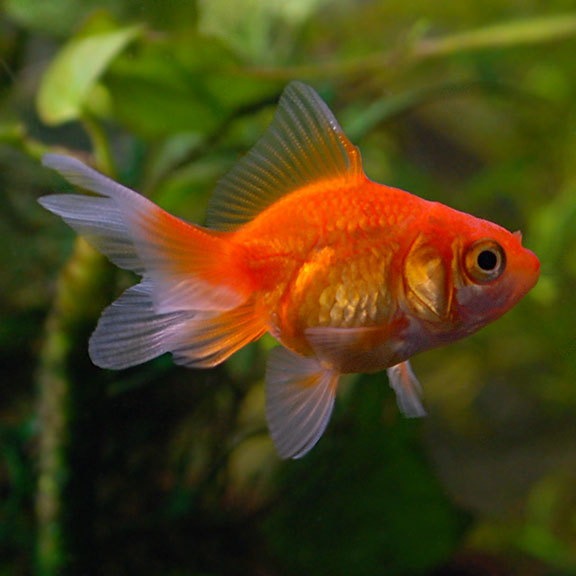

In [82]:
Image.open('goldfish.jpg')

In [83]:
gold_fish = Image.open('goldfish.jpg').resize(IMAGE_SHAPE)

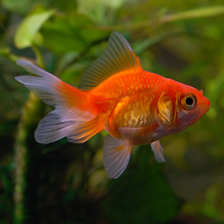

In [84]:
gold_fish

In [85]:
# making an array from a picture

gold_fish = np.array(gold_fish)/255

In [86]:
gold_fish.shape

(224, 224, 3)

In [87]:
gold_fish[np.newaxis, ...].shape

(1, 224, 224, 3)

In [88]:
result = classifier.predict(gold_fish[np.newaxis, ...])
result.shape

1/1 [==============================] - 0s 278ms/step


(1, 1001)

In [89]:
result

array([[ 0.22107819,  2.0497682 ,  9.622811  , ..., -1.4619302 ,
        -0.2823095 , -0.2591608 ]], dtype=float32)

In [90]:
predicted_label_index = np.argmax(result)
predicted_label_index

2

In [91]:
image_label = []
with open('ImageNetLabels.txt') as f:
    image_label = f.read().splitlines()

In [92]:
image_label[:2]

['background', 'tench']

In [93]:
image_label[predicted_label_index]

'goldfish'

In [94]:
dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
data_dir = tf.keras.utils.get_file('flower_photos', origin = dataset_url, cache_dir = '.', untar = True)

In [95]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [96]:
flowers_images_dict = {
    'roses' : list(data_dir.glob('roses/*')),
    'daisy' : list(data_dir.glob('daisy/*')),
    'dandelion' : list(data_dir.glob('dandelion/*')),
    'sunflower' : list(data_dir.glob('sunflower/*')),
    'tulips' : list(data_dir.glob('tulips/*'))
}

In [97]:
flowers_labels_dict = {
    'roses' : 0,
    'daisy' : 1,
    'dandelion' : 2,
    'sunflower' : 3,
    'tulips' : 4
}

In [98]:
str(flowers_images_dict['roses'][0])

'datasets/flower_photos/roses/16209331331_343c899d38.jpg'

In [99]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [100]:
img.shape

(243, 500, 3)

In [101]:
cv2.resize(img, IMAGE_SHAPE).shape

(224, 224, 3)

In [102]:
x, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, IMAGE_SHAPE)
        x.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [103]:
x = np.array(x)
y = np.array(y)

In [104]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [105]:
x_train_scaled = x_train/255
x_test_scaled = x_test/255

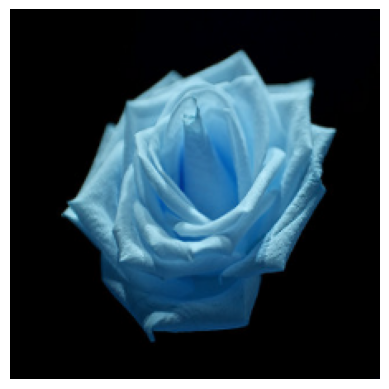

In [106]:
plt.axis('off')
plt.imshow(x[11])

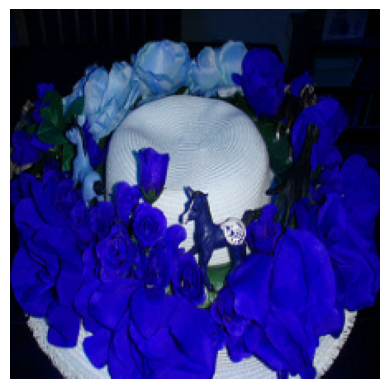

In [107]:
plt.axis('off')
plt.imshow(x[111])

In [108]:
predicted = classifier.predict(np.array([x[11], x[111]]))
predicted = np.argmax(predicted, axis = 1)
predicted

1/1 [==============================] - 0s 271ms/step


array([592, 795])

In [109]:
print(image_labels[530])
print(image_labels[432])

# predictions are incorrect because classifier list contains a thousand of categories. 
# And there is no even a 'flowers' category


diaper
bassinet


## Retraining the model

In [110]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(feature_extractor_model, 
                                                    input_shape = (224, 224, 3), 
                                                    trainable = False)

In [111]:
num_of_flowers = 5

model = tf.keras.Sequential([
    pretrained_model_without_top_layer,
    tf.keras.layers.Dense(num_of_flowers) # out top layer with 5 outputs instead of 1000
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [112]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
             metrics = ['accuracy'])

In [113]:
model.fit(x_train_scaled, y_train, epochs = 5) 
# here we got an accuracy of 94% in 5th epoch, while with just cnn training it was

Epoch 1/5
75/75 [==============================] - 18s 219ms/step - loss: 0.6213 - accuracy: 0.7664
Epoch 2/5
75/75 [==============================] - 17s 226ms/step - loss: 0.3178 - accuracy: 0.8864
Epoch 3/5
75/75 [==============================] - 18s 244ms/step - loss: 0.2527 - accuracy: 0.9133
Epoch 4/5
75/75 [==============================] - 18s 241ms/step - loss: 0.2148 - accuracy: 0.9247
Epoch 5/5
75/75 [==============================] - 18s 239ms/step - loss: 0.1857 - accuracy: 0.9423


In [114]:
model.evaluate(x_test_scaled, y_test)

19/19 [==============================] - 5s 225ms/step - loss: 0.3265 - accuracy: 0.8689


[0.3264749348163605, 0.8689075708389282]

##  On test data we've got an accuracy of 87% after 5 epochs using pretrained model,  while with just cnn training it was 10 epochs and 65% of accuracy 
see 'Flowers classification CNN' file